In [1]:
import networkx as nx
import random
import copy
from tqdm.notebook import tqdm

## Create

In [2]:
amazon_G = nx.read_graphml('./amazon_graph.graphml')

# Minimizar la distancia entre los nodos dentro de una comunidad
# Maximizar la distancia entre los nodos de disintas comunidades

In [3]:
def create_individuo(nodes_of_graph, adj_matrix, transformation):
    individuo =  [None] * len(nodes_of_graph)
    for i in range(len(nodes_of_graph)): #el individuo creado con el tipo locus tiene la longitud de los nodos

        
        nodo_vecino = random.choice(range(len(adj_matrix[i]))) #la matriz de adyacencia tiene los nodos vecinos, los nodos vecinos hay que convertirlos a numeros
        while adj_matrix[i][nodo_vecino] == 0 and nodo_vecino != i:
            nodo_vecino = random.choice(range(len(adj_matrix[nodo_vecino])))
        
        
        keys = list(transformation.keys())
        values = list(transformation.values())
        individuo[i] = keys[values.index(nodo_vecino)] # en el gen se pone el aleatorio de los vecinos pero transformado en el indice que le corresponde 
    return individuo

def create(nodes_of_graph, adj_matrix, transformation, N=100): # crea población, la transformacion debe de ser del tipo { numero_de_nodo_real : indice_del_array}, donde el indice del array va de 0 a len(nodos) - 1
    new_population = []
    for individuo in range(N):
        new_population.append(create_individuo(nodes_of_graph, adj_matrix, transformation))
    
    return new_population

In [4]:
conversiones = {}
for i, nodo in enumerate(amazon_G.nodes):
    conversiones[nodo] = i
print(conversiones)

{'75780': 0, '317458': 1, '186386': 2, '419862': 3, '176159': 4, '204831': 5, '104481': 6, '57383': 7, '401449': 8, '299055': 9, '176184': 10, '542780': 11, '366654': 12, '124992': 13, '16457': 14, '196682': 15, '546890': 16, '546891': 17, '34895': 18, '321619': 19, '112724': 20, '276567': 21, '55386': 22, '374874': 23, '55388': 24, '221281': 25, '432229': 26, '104553': 27, '383087': 28, '335987': 29, '448649': 30, '522378': 31, '59532': 32, '491667': 33, '518306': 34, '309411': 35, '182435': 36, '204966': 37, '532649': 38, '544939': 39, '542899': 40, '172218': 41, '270524': 42, '250046': 43, '204991': 44, '231620': 45, '497867': 46, '186575': 47, '346322': 48, '399572': 49, '276695': 50, '530647': 51, '18650': 52, '252125': 53, '59613': 54, '127199': 55, '379102': 56, '159972': 57, '366824': 58, '116969': 59, '202986': 60, '430314': 61, '350442': 62, '4328': 63, '458993': 64, '30962': 65, '35067': 66, '57600': 67, '217346': 68, '295177': 69, '49424': 70, '278': 71, '123159': 72, '3218

In [5]:
A = nx.to_numpy_array(amazon_G)

In [6]:
pop = create(amazon_G.nodes, A, conversiones)

## Fitness

In [7]:
def convert_individuo(individuo_raw, conversiones):
    new_individuo = [None] * len(individuo_raw)
    for i in range(len(individuo_raw)):
        new_individuo[i] = conversiones.get(str(individuo_raw[i]))
    
    return new_individuo
def unconvert_individuo(individuo, conversiones):
    individuo_raw =  [None] * len(individuo)
    keys = list(conversiones.keys())
    values = list(conversiones.values())
    for i in range(len(individuo)):
        individuo_raw[i] = keys[values.index(individuo[i])]
    return individuo_raw

def get_comunidades(individuo):

    G = nx.Graph()

    for i in range(len(individuo)):
        G.add_edge(i, individuo[i])

    comunidades = list(nx.connected_components(G))
    return comunidades

def get_cs(aristas_of_min_one_node_in_comunity, nodos_de_la_comunidad):
    cs = 0
    for aristas in aristas_of_min_one_node_in_comunity:
        if aristas[0] in nodos_de_la_comunidad and aristas[1] not in nodos_de_la_comunidad:
            cs += 1
            
        #elif aristas[1] in nodos_de_la_comunidad and aristas[0] not in nodos_de_la_comunidad:
        #    cs += 1
    return cs

def get_ms(aristas_of_min_one_node_in_comunity, nodos_de_la_comunidad):
    ms = 0
    for aristas in aristas_of_min_one_node_in_comunity:
        if aristas[0] in nodos_de_la_comunidad and aristas[1] in nodos_de_la_comunidad:
            ms += 1
            
        
    return ms

In [8]:
def fit_conductance(grafo,individuo,conversiones):
    conductance = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        for nodo_of_comunity in comunidad_desconvertida:

            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        #aqui ya tenemos las aristas de los nodos para poder sacar el sm
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        ms_community = get_ms(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        conductance += cs_community / (2*ms_community + cs_community)
        #
    
    return conductance
        
        
def fit_expansion(grafo,individuo,conversiones):
    expansion = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        for nodo_of_comunity in comunidad_desconvertida:

            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        #aqui ya tenemos las aristas de los nodos para poder sacar el sm
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        ns_community = len(comunidad_desconvertida)
        expansion += cs_community / ns_community
        #
    
    return expansion


def fit_average_odf(grafo,individuo,conversiones):
    average_odf = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        sum_nodos = 0
        for nodo_of_comunity in comunidad_desconvertida:
            aristas_del_nodo = list(grafo.edges(str(nodo_of_comunity)))[0]
            
            sum_nodos += get_cs(aristas_del_nodo,nodo_of_comunity) / len(aristas_del_nodo)
            #aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        average_odf += sum_nodos / len(comunidad)
        
        #aqui ya tenemos las aristas de los nodos para poder sacar el sm
        
        #
    
    return average_odf

def fit_Q(grafo,individuo,conversiones):
    Q = 0
    individuo_converted = convert_individuo(individuo, conversiones)
    comunidades = get_comunidades(individuo_converted)
    for comunidad in comunidades:
        aristas_of_min_one_node_in_comunity = []
        comunidad_desconvertida = unconvert_individuo(list(comunidad), conversiones)
        n_aristas = 0
        for nodo_of_comunity in comunidad_desconvertida:
            n_aristas += len(list(grafo.edges(str(nodo_of_comunity)))[0])
            aristas_of_min_one_node_in_comunity.append(list(grafo.edges(str(nodo_of_comunity)))[0])
        
        ms_community = get_ms(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        cs_community = get_cs(aristas_of_min_one_node_in_comunity, comunidad_desconvertida)
        
        Q += ((ms_community/n_aristas) - (((ms_community + cs_community)/(2*n_aristas))**2))
    
    return Q

## Select, Mutate y Crossover

In [9]:
def select (pop, fits, T): # devuelve un individuo seleccionado por torneo, devuelve una copia para evitar efectos laterales
    seleccionados = random.sample(pop, T) #los 3 aleatorios
    for i, indiv in enumerate(seleccionados):
        es_dominante = True
        for j, indiv2 in enumerate(seleccionados): 
            if i == j:
                continue
            
            if fits[i][0] > fits[j][0] and fits[i][1] > fits[j][1]:
                es_dominante = (True and es_dominante)
            else:
                es_dominante = (False and es_dominante)
        if es_dominante:
            return indiv
    return random.choice(seleccionados)

In [10]:
def mutate (grafo, ind, pmut, transformation): # la mutación consistirá en cambiar un elemento por otro posible nodo con el que este conectado
    probs = [random.random() for prob in range(len(ind))]
    nuevo_elem = copy.copy(ind)
    adj_matrix = nx.to_numpy_array(grafo)
    for i, probability in enumerate(probs):
      if probability < pmut:
            
        nodo_vecino = random.choice(range(len(adj_matrix[i]))) #la matriz de adyacencia tiene los nodos vecinos, los nodos vecinos hay que convertirlos a numeros
        
        while adj_matrix[i][nodo_vecino] == 0 and nodo_vecino != i:
            nodo_vecino = random.choice(range(len(adj_matrix[nodo_vecino])))
        
        keys = list(transformation.keys())
        values = list(transformation.values())
        nuevo_elem[i] = keys[values.index(nodo_vecino)] # en el gen se pone el aleatorio de los vecinos pero transformado en el indice que le corresponde 
    return nuevo_elem

In [11]:
def crossover (ind1, ind2, pcross, n_puntos = 1):
    copia_in1 = copy.copy(ind1)
    copia_in2 = copy.copy(ind2)
    if random.random() < pcross:
      punto = len(ind1) // (n_puntos+1)
      for i in range(n_puntos):
        index_fin = punto*(i+2)
        index_inicio = punto*(i+1)
        if index_fin < len(ind1):
          aux = copia_in1[index_inicio:index_fin]
          copia_in1[index_inicio:index_fin] = copia_in2[index_inicio:index_fin]
          copia_in2[index_inicio:index_fin] = aux
        else:
          aux = copia_in1[index_inicio:]
          copia_in1[index_inicio:] = copia_in2[index_inicio:]
          copia_in2[index_inicio:] = aux
    return copia_in1, copia_in2

# Evolve

In [12]:
def dominates(individual_A, individual_B):
    fit1_A, fit2_A = individual_A
    fit1_B, fit2_B = individual_B

    if fit1_B >= fit1_A and fit2_B >= fit2_A and (fit1_B > fit1_A or fit2_B > fit2_A):
        return True
    else:
        return False

def get_pareto_front(pop, fits):
    pareto_front = []
    pareto_fits = []
    for i, fit in enumerate(fits):
        if not any(dominates(fit, fits[j]) for j in range(len(pop)) if i != j):
            pareto_front.append(pop[i])
            pareto_fits.append(fits[i])
    return pareto_front, pareto_fits

Esta funcion añade a la poblacion de la siguiente generacion los individuos restantes para que de el tamaño de la poblacion total

In [13]:
import math
def get_pareto_fronts(pop, fits):
    pareto_fronts = []
    pareto_fits = []

    remaining_pop = copy.copy(pop)
    remaining_fits = copy.copy(fits)

    while remaining_pop:
        current_pareto, current_fits = get_pareto_front(remaining_pop, remaining_fits)
        pareto_fronts.append(current_pareto)
        pareto_fits.append(current_fits)

        indices_to_remove = [remaining_pop.index(ind) for ind in current_pareto]
        remaining_pop = [ind for i, ind in enumerate(remaining_pop) if i not in indices_to_remove]
        remaining_fits = [fit for i, fit in enumerate(remaining_fits) if i not in indices_to_remove]

    return pareto_fronts, pareto_fits

def select_resto_pop(len_pop, len_pareto_front, pop, fits, T=3):
    num_of_pop_to_fill = len_pop - len_pareto_front
    pop_fill = []
    for _ in range(num_of_pop_to_fill):
        ind = select(pop, fits, T)
        pop_fill.append(ind)
    return pop_fill

In [58]:
def evolve(pop, fit1, fit2, grafo, conversiones, T=3, pcross=0.8, pmut=0.2, n_puntos=1, n_gen=10, fit1_maximize=False, fit2_maximize=False):
    fitness1 = fit1 if fit1_maximize else lambda grafo, ind, conversione: 1 / (fit1(grafo, ind, conversione) + 1e-10)
    fitness2 = fit2 if fit2_maximize else lambda grafo, ind, conversione: 1 / (fit2(grafo, ind, conversione) + 1e-10)

    max_len = len(pop)


    for n in range(n_gen):
        print(f"N_GEN = {n}")
        new_pop = []
        fits = [(fitness1(grafo, ind, conversiones), fitness2(grafo, ind, conversiones)) for ind in pop]

        paretos = get_pareto_fronts(pop, fits)

        if len(paretos[0]) >= 5:
            i = 1
            print(len(paretos[0][0]))
            for (pareto_pop, pareto_fits) in zip(*paretos):
                for _ in range(len(pop) // ((i+1)*2)):
                    if T <= len(pareto_pop):
                        parent1 = select(pareto_pop, pareto_fits, T)
                        parent2 = select(pareto_pop, pareto_fits, T)
                    else:
                        parent1 = select(pareto_pop, pareto_fits, len(pareto_pop))
                        parent2 = select(pareto_pop, pareto_fits, len(pareto_pop))

                    offspring1, offspring2 = crossover(parent1, parent2, pcross=pcross, n_puntos=n_puntos)

                    offspring1 = mutate(amazon_G, offspring1, pmut=pmut, transformation=conversiones)
                    offspring2 = mutate(amazon_G, offspring2, pmut=pmut, transformation=conversiones)

                    new_pop.extend([offspring1, offspring2])

                pop = new_pop

                i += 1
                if len(new_pop) >= max_len:
                    pop = new_pop[:max_len]
                    break
    
    return pop
    

In [59]:
evolved_pop = evolve(pop, fit_average_odf, fit_Q, amazon_G, conversiones, T=3, n_gen=50, fit2_maximize=True, pcross=0.3)
# evolved_pop

N_GEN = 0
5
N_GEN = 1
5
N_GEN = 2
5
N_GEN = 3
11
N_GEN = 4
5
N_GEN = 5
8
N_GEN = 6
5
N_GEN = 7
8
N_GEN = 8
1
N_GEN = 9
4
N_GEN = 10
4
N_GEN = 11
5
N_GEN = 12
7
N_GEN = 13
7
N_GEN = 14
3
N_GEN = 15
4
N_GEN = 16
4
N_GEN = 17
6
N_GEN = 18
5
N_GEN = 19
5
N_GEN = 20
7
N_GEN = 21
6
N_GEN = 22
6
N_GEN = 23
5
N_GEN = 24
7
N_GEN = 25
5
N_GEN = 26
6
N_GEN = 27
7
N_GEN = 28
11
N_GEN = 29
6
N_GEN = 30
6
N_GEN = 31
5
N_GEN = 32
3
N_GEN = 33
4
N_GEN = 34
7
N_GEN = 35
6
N_GEN = 36
7
N_GEN = 37
8
N_GEN = 38
6
N_GEN = 39
5
N_GEN = 40
4
N_GEN = 41
8
N_GEN = 42
5
N_GEN = 43
5
N_GEN = 44
6
N_GEN = 45
10
N_GEN = 46
4
N_GEN = 47
9
N_GEN = 48
6
N_GEN = 49
5


long 100
fit1 : [12.119506398744015, 12.755643212996153, 14.931888169301963, 12.911196001251517, 13.150754542125846, 10.663022931884827, 11.583636792904526, 12.001816863495756, 11.739823656735423, 12.944298980589304, 13.186650206059435, 12.397001901607164, 13.794579642064162, 11.731225718725717, 10.451594828067941, 11.593031456847246, 12.788236885663355, 13.0295636338206, 11.425686535686538, 14.048946192696192, 15.142021720969089, 12.165286253134548, 12.641364191364191, 11.459061300345459, 14.04156195928255, 16.379012572394927, 14.345794775400039, 11.724971556221554, 14.246702725379194, 13.835137085137085, 11.496295923312053, 11.760129515979898, 11.70108298564181, 10.72887099284158, 13.31970809454825, 12.229193722943723, 11.981269465828289, 12.507814407814406, 11.816512776439245, 14.012866338138569, 12.789514104316737, 12.730736234140965, 15.381159410764674, 11.914601180629406, 14.092765432451964, 12.607273282273281, 12.30402105849087, 10.555718969750131, 10.804063858398225, 13.0678569

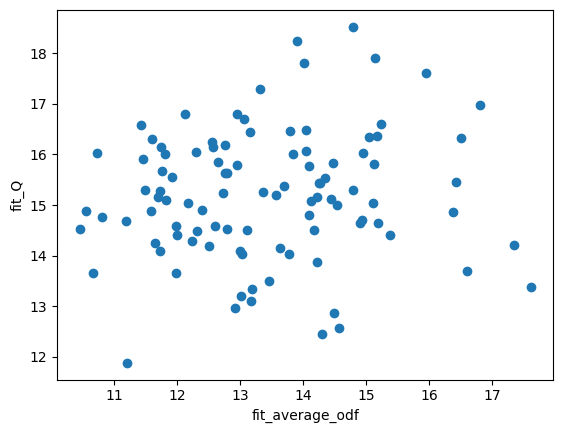

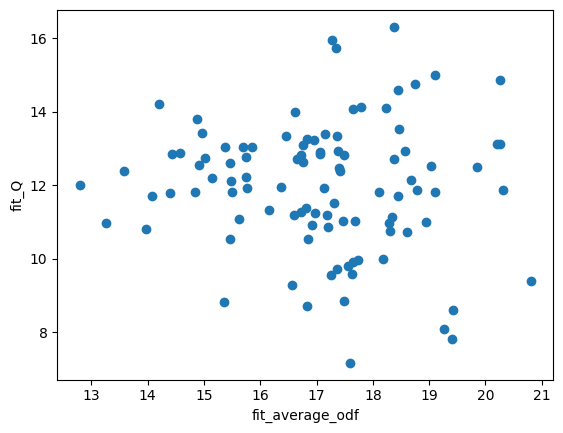

In [61]:
import matplotlib.pyplot as plt

# pop = create(amazon_G.nodes, A, conversiones)

print(f"long {len(evolved_pop)}")
fits1 = []
fits2 = []

for ind in evolved_pop:
    fits1.append(fit_average_odf(amazon_G, ind, conversiones))
    fits2.append(fit_Q(amazon_G, ind, conversiones))

print(f"fit1 : {fits1}")
print(f"fit2 : {fits2}")

plt.scatter(fits1, fits2)
plt.xlabel('fit_average_odf')
plt.ylabel('fit_Q')

plt.show()

fits1 = []
fits2 = []

for ind in pop:
    fits1.append(fit_average_odf(amazon_G, ind, conversiones))
    fits2.append(fit_Q(amazon_G, ind, conversiones))

plt.scatter(fits1, fits2)
plt.xlabel('fit_average_odf')
plt.ylabel('fit_Q')

plt.show()


In [17]:
get_comunidades(evolved_pop[0])

IndexError: list index out of range